Accuracy (from-scratch GaussianNB): 0.9211

Classification report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.86      0.92      0.89        13
   virginica       0.92      0.85      0.88        13

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38

Confusion matrix:
 [[12  0  0]
 [ 0 12  1]
 [ 0  2 11]]

Class means:
             sepal length (cm)  sepal width (cm)  petal length (cm)  \
setosa               4.994737          3.450000           1.481579   
versicolor           5.997297          2.743243           4.264865   
virginica            6.664865          2.994595           5.608108   

            petal width (cm)  
setosa              0.247368  
versicolor          1.310811  
virginica           2.048649  

Class variances:
             sepal length (cm)  sepal width (cm)  petal l

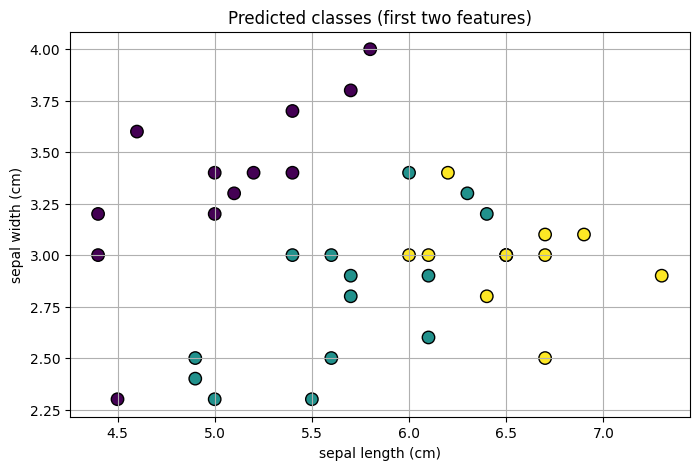

In [1]:
#step-by-step Gaussian Naive Bayes implementation
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load Iris
iris = datasets.load_iris()
X = iris.data         # shape (150, 4)
y = iris.target       # shape (150,)
feature_names = iris.feature_names
class_names = iris.target_names

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

class GaussianNBFromScratch:
    """
    Simple vectorized Gaussian Naive Bayes classifier.
    Assumes features are continuous and follow class-conditional Gaussian distributions.
    """
    def __init__(self, var_smoothing=1e-9):
        # var_smoothing: small value added to variance for numerical stability
        self.var_smoothing = var_smoothing

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_features = X.shape[1]
        n_classes = self.classes_.shape[0]

        # Initialize containers
        self.class_prior_ = np.zeros(n_classes)
        self.theta_ = np.zeros((n_classes, n_features))  # mean per class per feature
        self.sigma_ = np.zeros((n_classes, n_features))  # variance per class per feature

        # Compute priors, means, variances
        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]
            self.class_prior_[idx] = X_c.shape[0] / X.shape[0]
            self.theta_[idx, :] = X_c.mean(axis=0)
            # unbiased variance (ddof=0) like sklearn: population variance
            self.sigma_[idx, :] = X_c.var(axis=0) + self.var_smoothing

    def _gaussian_log_likelihood(self, X):
        """
        Compute the log likelihood log P(X | class) for each class.
        Returns array shape (n_samples, n_classes)
        """
        n_samples, n_features = X.shape
        n_classes = self.classes_.shape[0]
        log_likelihood = np.zeros((n_samples, n_classes))

        # Vectorized formula for log N(x | mu, var)
        # log N = -0.5 * [ log(2*pi*var) + (x-mu)^2 / var ]
        for idx in range(n_classes):
            mu = self.theta_[idx]
            var = self.sigma_[idx]
            # compute term for all samples at once: broadcasting (n_samples, n_features)
            term1 = -0.5 * np.sum(np.log(2.0 * np.pi * var))
            term2 = -0.5 * np.sum(((X - mu) ** 2) / var, axis=1)
            log_likelihood[:, idx] = term1 + term2
        return log_likelihood

    def predict(self, X):
        # Calculate log posterior = log prior + log likelihood
        log_prior = np.log(self.class_prior_)
        log_likelihood = self._gaussian_log_likelihood(X)   # (n_samples, n_classes)
        log_posterior = log_likelihood + log_prior  # broadcasting
        # choose class with highest posterior
        class_indices = np.argmax(log_posterior, axis=1)
        return self.classes_[class_indices]

    def predict_proba(self, X):
        # Return normalized posterior probabilities (softmax over log_posteriors)
        log_prior = np.log(self.class_prior_)
        log_likelihood = self._gaussian_log_likelihood(X)   # (n_samples, n_classes)
        log_posterior = log_likelihood + log_prior
        # to avoid overflow use log-sum-exp trick
        max_lp = np.max(log_posterior, axis=1, keepdims=True)
        exp_lp = np.exp(log_posterior - max_lp)
        probs = exp_lp / np.sum(exp_lp, axis=1, keepdims=True)
        return probs

# Train
gnb_scratch = GaussianNBFromScratch()
gnb_scratch.fit(X_train, y_train)

# Predict
y_pred = gnb_scratch.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy (from-scratch GaussianNB): {:.4f}".format(acc))
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Optionally, show class means and variances
means_df = pd.DataFrame(gnb_scratch.theta_, index=class_names, columns=feature_names)
vars_df = pd.DataFrame(gnb_scratch.sigma_, index=class_names, columns=feature_names)
print("\nClass means:\n", means_df)
print("\nClass variances:\n", vars_df)

# Optional visualization: pairplot-like scatter for first two features with predicted labels
plt.figure(figsize=(8,5))
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred, marker='o', edgecolor='k', s=80)
plt.title("Predicted classes (first two features)")
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.grid(True)
plt.show()


Accuracy (sklearn GaussianNB): 0.9211

Classification report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.86      0.92      0.89        13
   virginica       0.92      0.85      0.88        13

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38

Confusion matrix:
 [[12  0  0]
 [ 0 12  1]
 [ 0  2 11]]

Sample predicted probabilities (first 5 test samples):
           setosa    versicolor     virginica
0   1.000000e+00  3.058990e-20  5.939279e-27
1  1.758500e-135  6.390746e-01  3.609254e-01
2   8.776343e-88  9.999361e-01  6.387859e-05
3   4.262845e-83  9.999839e-01  1.614444e-05
4   1.000000e+00  1.240216e-19  1.232017e-26


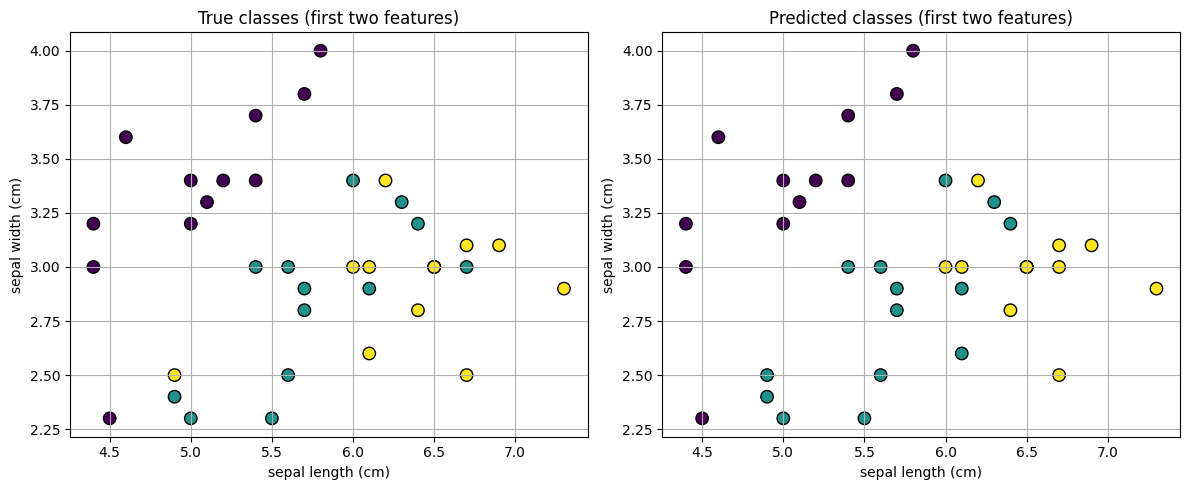

In [2]:
#use of sklearn's GaussianNB
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load Iris
iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
class_names = iris.target_names

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Create and train
gnb = GaussianNB(var_smoothing=1e-9)  # default hyperparam; change if needed
gnb.fit(X_train, y_train)

# Predict and evaluate
y_pred = gnb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy (sklearn GaussianNB): {:.4f}".format(acc))
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Optional: predicted probabilities
probs = gnb.predict_proba(X_test)  # shape (n_samples, n_classes)
print("\nSample predicted probabilities (first 5 test samples):\n", pd.DataFrame(probs[:5], columns=class_names))

# Optional visualization: first two features scatter with true vs predicted
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, edgecolor='k', s=80)
plt.title("True classes (first two features)")
plt.xlabel(feature_names[0]); plt.ylabel(feature_names[1])
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred, edgecolor='k', s=80)
plt.title("Predicted classes (first two features)")
plt.xlabel(feature_names[0]); plt.ylabel(feature_names[1])
plt.grid(True)

plt.tight_layout()
plt.show()


In [3]:
#GridSearchCV for finding best K in KNN

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Load dataset
X, y = load_iris(return_X_y=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pipeline: Scaling + KNN
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# Parameter grid for K
param_grid = {
    "knn__n_neighbors": range(1, 21)   # Test K = 1 to 20
}

# Grid Search
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

# Best K and accuracy
print("Best K:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)
print("Test Accuracy:", grid.score(X_test, y_test))


Best K: {'knn__n_neighbors': 5}
Best CV Accuracy: 0.9666666666666668
Test Accuracy: 0.9333333333333333
